#Fine-Tuning BERT for Sentiment Analysis
This notebook demonstrates how to fine-tune a pre-trained BERT model for sentiment classification on the IMDb movie reviews dataset.

Dataset: IMDb Large Movie Review Dataset.

Task: Binary sentiment classification (positive / negative).

Model: BERT base model (bert-base-uncased) from Hugging Face Transformers.

Framework: TensorFlow.

## (1) Mount Google Drive
Mount Google Drive to access files stored in your drive for running this project.



In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##(2) Download IMDb Dataset from Kaggle
This section handles Kaggle authentication using an API key stored in Google Drive and downloads the IMDb movie review dataset directly into the working directory.  
The dataset is stored in a structured location to simplify access and processing in later steps.

In [ ]:
import os

# Create Kaggle directory (if not exists)
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy kaggle.json from your Drive to Kaggle location
!cp /content/drive/MyDrive/DataCoach/kaggle.json /root/.kaggle/

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json

# Install kaggle CLI
!pip install -q kaggle

# Define your working directory
working_dir = '/content/drive/MyDrive/DataCoach'

# Download dataset directly into your Drive folder
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p {working_dir}

# Unzip inside your Drive folder
!unzip {working_dir}/imdb-dataset-of-50k-movie-reviews.zip -d {working_dir}

##(3) Install Required Libraries
Installs the specific versions of TensorFlow, Keras, and Hugging Face Transformers required for fine-tuning the BERT model using TensorFlow.
Using fixed versions ensures compatibility and reproducibility of the training pipeline.

In [ ]:
%pip install -q tensorflow==2.12 keras==2.12
%pip install -q tf-keras
%pip install -q transformers
!pip install -q lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 31.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.1

## (4) Data Preparation
This section loads the IMDb dataset, visualizes the class distribution, maps sentiment labels to binary values, and splits the data into training and test sets for further processing.


### Load and Explore the Dataset

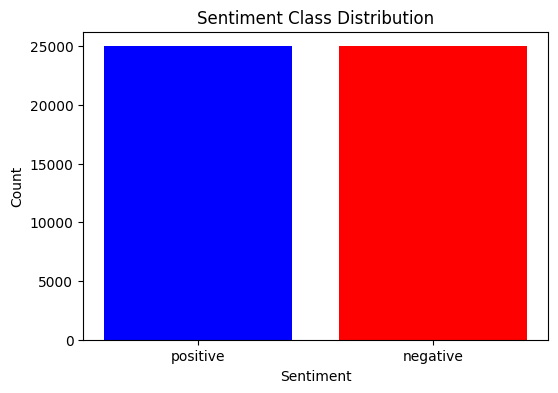

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/DataCoach/IMDB Dataset.csv')

# Count how many positives and negatives
label_counts = df['sentiment'].value_counts()

# Plot
plt.figure(figsize=(6,4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'])
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()



###  Encode Labels and Split into Train/Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# map sentiment to 0/1 labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# split into train and test (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print sizes
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")



Train size: 40000
Test size: 10000


## (5) Prepare Data for BERT
This section transforms raw text reviews and labels into a format compatible with the BERT model.  
It includes tokenization, encoding of input features (input IDs, attention masks, and token type IDs), and batching the data for training and evaluation.

### Convert pandas → tf.data.Dataset

In [ ]:
import tensorflow as tf

# Convert train
train_ds = tf.data.Dataset.from_tensor_slices((
    train_df['review'].values,
    train_df['label'].values
))

# Convert test
test_ds = tf.data.Dataset.from_tensor_slices((
    test_df['review'].values,
    test_df['label'].values
))

###Initialize BERT Tokenizer (`bert-base-uncased`)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


###Define Function to Tokenize and Format a Single Review for BERT

In [ ]:
def convert_example_to_feature(review):
    return tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True
    )


### Define Tokenization and Batching Parameters
Defines the maximum number of tokens per review and the number of samples per batch during training, both required for preparing inputs for the BERT model.


In [ ]:
max_length = 512
batch_size = 6

###  Encode Dataset into BERT-Compatible Format
Defines the `encode_examples()` function to convert raw text and labels into tokenized BERT input features (`input_ids`, `attention_mask`, `token_type_ids`).  
Also includes a helper function to format inputs as expected by TensorFlow, and enables eager execution for compatibility with dynamic operations.



In [ ]:
import tensorflow as tf

# Enable eager execution to allow for-each loops to work properly
tf.config.run_functions_eagerly(True)

# Helper function: format BERT inputs as a dictionary TensorFlow expects.
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }, label

# Main function: convert dataset examples to BERT input format
def encode_examples(ds, limit=-1):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    if limit > 0:
        ds = ds.take(limit)

    for review, label in ds:
        review_text = review.numpy().decode('utf-8')
        bert_input = convert_example_to_feature(review_text)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label.numpy()])

    return tf.data.Dataset.from_tensor_slices(
        (
            tf.convert_to_tensor(input_ids_list),
            tf.convert_to_tensor(attention_mask_list),
            tf.convert_to_tensor(token_type_ids_list),
            tf.convert_to_tensor(label_list)
        )
    ).map(map_example_to_dict)


### Prepare Final BERT Datasets for Training and Evaluation
Applies the `encode_examples()` function to transform the training and test datasets into BERT input format.  
The training dataset is shuffled and batched, while the test dataset is only batched to preserve order during evaluation.

In [ ]:

ds_train_encoded = encode_examples(train_ds).shuffle(10000).batch(batch_size)

ds_test_encoded = encode_examples(test_ds).batch(batch_size)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


## (6) Fine-Tune BERT for Sentiment Classification
This section initializes and compiles the BERT model for binary sentiment classification, then fine-tunes it using the IMDb dataset.  
The trained model and tokenizer are saved to Google Drive for later use.

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

learning_rate = 2e-5
number_of_epochs = 1

# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train (fine-tune) the BERT model on the sentiment classification task using the IMDB dataset.

bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs)

# Save model to Drive
output_dir = "/content/drive/MyDrive/DataCoach/sentiment_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

6667/6667 [==============================] - 7171s 1s/step - loss: 0.2152 - accuracy: 0.9156


('/content/drive/MyDrive/DataCoach/sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/DataCoach/sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/DataCoach/sentiment_model/vocab.txt',
 '/content/drive/MyDrive/DataCoach/sentiment_model/added_tokens.json')

## (7) Model Interpretability with LIME
This section uses LIME (Local Interpretable Model-agnostic Explanations) to analyze how the fine-tuned BERT model interprets individual words in a sample review.  
The goal is to understand which words influence the model's predictions — helping explain why the accuracy is not perfect and what patterns BERT may be relying on.

Some layers from the model checkpoint at /content/drive/MyDrive/DataCoach/sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/DataCoach/sentiment_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
<ipython-inpu

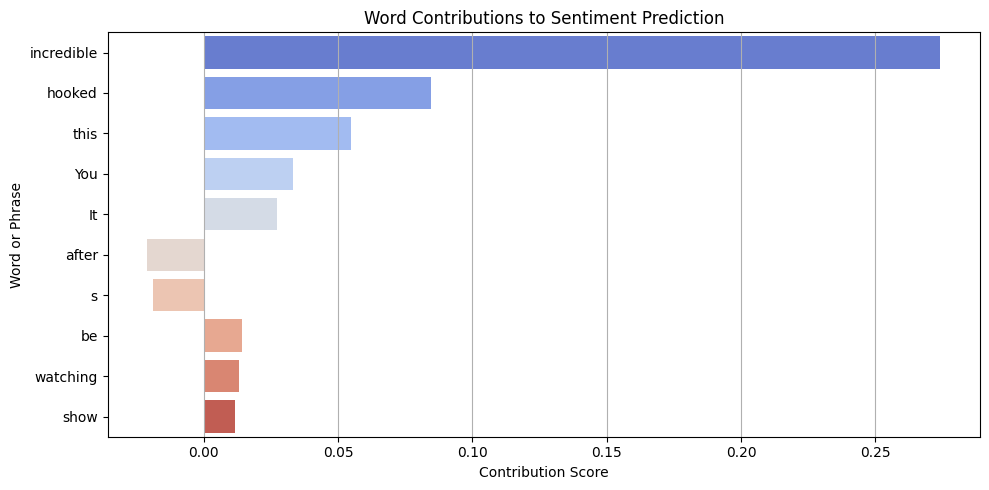

In [ ]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# === Load trained tokenizer and model ===
model_path = "/content/drive/MyDrive/DataCoach/sentiment_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = TFBertForSequenceClassification.from_pretrained(model_path)

# === Define class labels ===
class_names = ['negative', 'positive']

# === Wrapper: predict function for LIME ===
def predict_proba(texts):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="tf"
    )
    outputs = model(encodings)
    probs = tf.nn.softmax(outputs.logits, axis=1).numpy()
    return probs

# === Create LIME explainer ===
explainer = LimeTextExplainer(class_names=class_names)

# === Example sentence for explanation ===
sample_text = "You'll be hooked after watching this show. It's incredible."

# === Generate LIME explanation ===
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)

# === Convert explanation to DataFrame ===
exp_df = pd.DataFrame(exp.as_list(), columns=["Word", "Contribution"])

# === Plot contributions ===
plt.figure(figsize=(10, 5))
sns.barplot(data=exp_df, y="Word", x="Contribution", palette="coolwarm")
plt.title("Word Contributions to Sentiment Prediction")
plt.xlabel("Contribution Score")
plt.ylabel("Word or Phrase")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()




## (8) Evaluate Model Performance on Test Set

This section reloads the fine-tuned BERT model and tokenizer from Drive, generates predictions on the test set, and evaluates the model using precision, recall, and F1-score.  
The classification report provides insights into how well the model performs on each sentiment class.


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf

# Load saved model and tokenizer from Drive
model_path = "/content/drive/MyDrive/DataCoach/sentiment_model"

model = TFBertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)


from sklearn.metrics import classification_report
import numpy as np

# Extract true labels
y_true = []
for _, label in test_ds:
    y_true.append(label.numpy())

# Predict labels
y_pred = []
for batch in ds_test_encoded:
    inputs, _ = batch
    logits = model(inputs, training=False).logits
    preds = tf.argmax(logits, axis=1).numpy()
    y_pred.extend(preds)

# Show classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))




Some layers from the model checkpoint at /content/drive/MyDrive/DataCoach/sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/DataCoach/sentiment_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.



Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.94      0.94      5000
    Positive       0.94      0.95      0.95      5000

    accuracy                           0.94     10000
   macro avg       0.95      0.95      0.94     10000
weighted avg       0.95      0.94      0.94     10000



## (9) Interactive Sentiment Prediction

This section loads the trained model and tokenizer, defines a function to predict sentiment for any given sentence, and runs an interactive loop for real-time testing.  
Users can input custom text to see how the model classifies it as positive or negative.


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
import numpy as np

# Load trained model and tokenizer from Drive
model_path = "/content/drive/MyDrive/DataCoach/sentiment_model"
model = TFBertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Function to predict sentiment from a raw sentence
def predict_sentiment(text):
    # Tokenize input
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='tf'  # Return as TensorFlow tensors
    )

    # Predict
    logits = model(inputs).logits
    predicted_class = int(tf.argmax(logits, axis=1).numpy()[0])

    # Map result to label
    label = "Positive" if predicted_class == 1 else "Negative"
    return label

# === Live input ===
while True:
    text_input = input("Enter your sentence (or type 'end' to stop): ")
    if text_input.strip().lower() == "end":
        print("Exiting prediction loop.")
        break
    result = predict_sentiment(text_input)
    print(f"\nPredicted Sentiment: {result}\n")


Some layers from the model checkpoint at /content/drive/MyDrive/DataCoach/sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/DataCoach/sentiment_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Enter your sentence (or type 'end' to stop): death

Predicted Sentiment: Negative

